# Callbacks and Tensorboard

We'll go over various callbacks such as:

* Early Stopping
* History (Especially useful for functional models)
* Model History
* Tensorboard
* Model Accuracy and Loss Graphs

In [13]:
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model, model_from_json
tensorflow.keras.__version__

'2.2.4-tf'

In [14]:
train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

In [15]:
train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224))

Found 12894 images belonging to 10 classes.


In [16]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    'data/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(224, 224))

Found 500 images belonging to 10 classes.


In [17]:
conv_base = ResNet50(include_top=False, weights='imagenet')

In [18]:
# Freeze all of the base layers
for layer in conv_base.layers:
    layer.trainable = False# Freeze all of the base layers

In [19]:
x  = conv_base.output
x = layers.GlobalAveragePooling2D()(x)

predictions = layers.Dense(10, activation='softmax', name='fc3')(x)

In [20]:
model = Model(conv_base.input, predictions)

In [21]:
#model.summary()

In [22]:
opt = tensorflow.keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## Callbacks

Callbacks are a good way to:

* get feedback about training while training
* save history for analysis
* checkpoint save your model whenever performance increases

You can use Tensorboard for advanced diagnostics and graph view

You will need this command for Tensorboard: `logdir=graph/ --host 0.0.0.0 --port 8999`

In [23]:
filepath = 'models/weights.{epoch:02d}-{val_loss:.2f}.hdf5'

stopping_criterion = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)

history = keras.callbacks.History()

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(log_dir='graph', histogram_freq=0, write_graph=True)

callbacks = [stopping_criterion, history, checkpoint, tensorboard]

In [24]:
history = model.fit_generator(
    generator=train_generator,
    epochs = 4,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/4
402/403 [============================>.] - ETA: 0s - loss: 0.3583 - accuracy: 0.8905
Epoch 00001: val_accuracy improved from -inf to 0.95800, saving model to models/weights.01-0.14.hdf5
403/403 [==============================] - 155s 386ms/step - loss: 0.3587 - accuracy: 0.8903 - val_loss: 0.1362 - val_accuracy: 0.9580
Epoch 2/4
402/403 [============================>.] - ETA: 0s - loss: 0.1832 - accuracy: 0.9418
Epoch 00002: val_accuracy improved from 0.95800 to 0.96000, saving model to models/weights.02-0.13.hdf5
403/403 [==============================] - 151s 376ms/step - loss: 0.1831 - accuracy: 0.9419 - val_loss: 0.1272 - val_accuracy: 0.9600
Epoch 3/4
402/403 [============================>.] - ETA: 0s - loss: 0.1529 - accuracy: 0.9510
Epoch 00003: val_accuracy did not improve from 0.96000
403/403 [==============================] - 153s 380ms/step - loss: 0.1527 - accuracy: 0.9511 - val_loss: 0.1375 - val_accuracy: 0.9580
Epoch 4/4
402/403 [============================>.]

## Model Accuracy and Loss Graphs

These graphs will show us how our model performed

We can get and idea of whether it is underfitting or overfitting

You can also view these graphs in tensorboard

In [25]:
import matplotlib.pyplot as plt

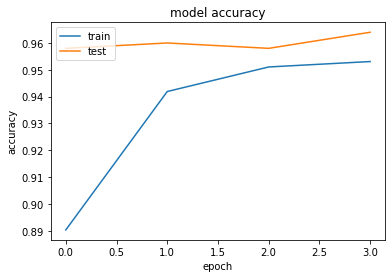

In [28]:
# Summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

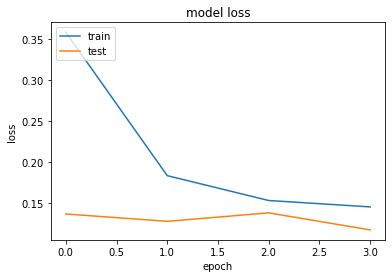

In [29]:
# Summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## History Callback Gotcha

If you use `load_model()` on your saved model and try to access history it will throw an error

So if you want to see these graphs in a notebook you need to do it in the notebook you trained the model in